In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from rasterio.errors import RasterioIOError
import csv
from skimage import io
import requests
from PIL import Image
from io import BytesIO

In [468]:
tile = '11SKU'
location = 'Isla_Vista_Kelp'
cloud_cover_threshold = .25
save_mask = True
save_classification = True
path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery',location,tile)
item = 'HLS.L30.T11SKU.2021306T183432.v2.0'

#img_path = r'C:\Users\attic\HLS_Kelp\imagery\Isla_Vista_Kelp\10SGD\HLS.L30.T10SGD.2017167T183413.v2.0'

In [469]:
img_path = os.path.join(path,item)
files = os.listdir(img_path)
file_data = item.split('.')
sensor = file_data[1]
if(sensor == 'L30'):
    sensor_bands = ['B02','B03','B04','B05','B06','B07'] #2,3,4,5,6,7]
else:
    sensor_bands = ['B02','B03','B04','B8A','B11','B12']
pattern = re.compile(r'\.(' + '|'.join(sensor_bands) + r')\.tif$')
img_files = [f for f in files if re.search(pattern, f)]

geotiff_path = os.path.join(img_path, img_files[0])

with rasterio.open(geotiff_path) as dst:   
    hls = dst.read()
    dem_path = r'C:\Users\attic\HLS_Kelp\imagery\Socal_DEM.tiff'
    dem = rasterio.open(dem_path)
    if (dem.crs != dst.crs):
        reprojected_dem = np.zeros((hls.shape[1], hls.shape[2]), dtype=hls.dtype)
        reproject(
            source=dem.read(),
            destination=reprojected_dem,
            src_transform=dem.transform,
            src_crs=dem.crs,
            dst_transform=dst.transform,
            dst_crs=dst.crs,
            resampling=Resampling.bilinear)
    hls_flat = np.squeeze(hls, axis=0)   

if reprojected_dem.any():
    struct = np.ones((5,5))
    land_mask = binary_dilation(reprojected_dem > 0, structure = struct)
    ocean_mask = binary_dilation(reprojected_dem < -60 , structure = struct)
    full_mask = land_mask + ocean_mask
    # plt.figure(figsize=(6, 6))
    # plt.imshow(land_mask, cmap='gray')
    # plt.show()    
    # plt.figure(figsize=(6, 6))
    # plt.imshow(full_mask, cmap='gray')
    # plt.show()
    if save_mask:
        mask_path = os.path.join(path,f'{tile}_fullmask.tif')
        transform = dst.transform  
        height, width = full_mask.shape
        profile = {
            'driver': 'GTiff',
            'width': width,
            'height': height,
            'count': 1,  # one band
            'dtype': rasterio.uint8,  # assuming binary mask, adjust dtype if needed
            'crs': dst.crs,
            'transform': transform,
            'nodata': 0  # assuming no data is 0
        }

        # Write the land mask array to GeoTIFF
        with rasterio.open(mask_path, 'w', **profile) as dst:
            dst.write(full_mask.astype(rasterio.uint8), 1)
else:
    print("Something failed, you better go check...")

In [470]:

 ##==========Select Granule and Get File Names==========##

files = os.listdir(img_path)
img_files = [f for f in files if re.search(pattern, f)]
f_mask = [f for f in files if re.search(r'Fmask\.tif$', f)]

if not len(img_files)  == 6:
    print(f"incomplete file download: {item}")
img_bands = []
metadata_file = [f for f in files if re.search(r'metadata\.csv$', f)]
if metadata_file :
    with open(os.path.join(path,item, metadata_file[0]), mode='r') as file:
        csv_reader = csv.reader(file)
        keys = next(csv_reader)  
        values = next(csv_reader) 
    metadata = dict(zip(keys, values))

##==========Fmask Cloud mask==========##
#bitwise operations are weird. Far outside my comfort zone. Need to take CS33 first.........
with rasterio.open(os.path.join(img_path,f_mask[0])) as fmask:
    qa_band = fmask.read(1)
qa_bit = (1 << 1) - 1
qa_cloud_mask = ((qa_band >> 1) & qa_bit) == 1  # Bit 1 for cloud
qa_adjacent_to_cloud_mask = ((qa_band >> 2) & qa_bit) == 1  # Bit 2 for cloud adjacent
qa_cloud_shadow = ((qa_band >> 3) & qa_bit) == 1 
qa_ice = ((qa_band >> 4) & qa_bit) == 1 
#qa_water = ((qa_band >> 5) & qa_bit) == 1
qa_aerosol = (((qa_band >> 6) & 1) == 1) & (((qa_band >> 7) & 1) == 1)
cloud_mask = qa_cloud_mask | qa_cloud_shadow | qa_ice #| qa_aerosol#Mask out Clouds and cloud-adjacent pixels 
cloud_mask_2D = cloud_mask.reshape(-1).T
#may not be necessary to mask out the cloud-adjacent pixels 
#print(img_2D_normalized.shape)
#print(cloud_mask_2D.shape)

##========== Determine percentage of ocean covered by clouds ==========##
cloud_land_mask = cloud_mask | land_mask
cloud_but_not_land_mask = cloud_mask & ~land_mask
num_pixels_cloud_not_land = np.count_nonzero(cloud_but_not_land_mask)
num_pixels_not_land = np.count_nonzero(land_mask)
percent_cloud_covered = num_pixels_cloud_not_land/num_pixels_not_land
print(f'Percent cloud covered: {percent_cloud_covered}')

##==========Create stacked np array, Apply landmask==========##
try:
    for file in img_files:
        with rasterio.open(os.path.join(img_path, file)) as src:
            img_bands.append(np.where(cloud_land_mask, 0, src.read(1)))  # Create image with the various bands
except RasterioIOError as e:
    print(f"Error reading file {file} in granule {item}: {e}")

img = np.stack(img_bands, axis=0)
n_bands, height, width = img.shape
img_2D = img.reshape(img.shape[0], -1).T #classifier takes 2D array of band values for each pixel 

##========== Normalize multi-spectral data ==========##
img_sum = img_2D.sum(axis=1)
epsilon = 1e-10  

img_2D_normalized = np.divide(img_2D, img_sum[:, None] + epsilon, where=(img_sum[:, None] != 0))
img_2D_normalized = (img_2D_normalized * 255).astype(np.uint8)
#normalized_img_bands = np.column_stack((img_2D_normalized, cloud_mask_2D))

Percent cloud covered: 0.046825263855887714


In [471]:
n_clusters_1 = 15 #set this to determine number of clusters
kmeans = KMeans(n_clusters=n_clusters_1, random_state=42)
clusters_1 = kmeans.fit_predict(img_2D_normalized)
kmeans_1 = clusters_1.reshape((height, width))

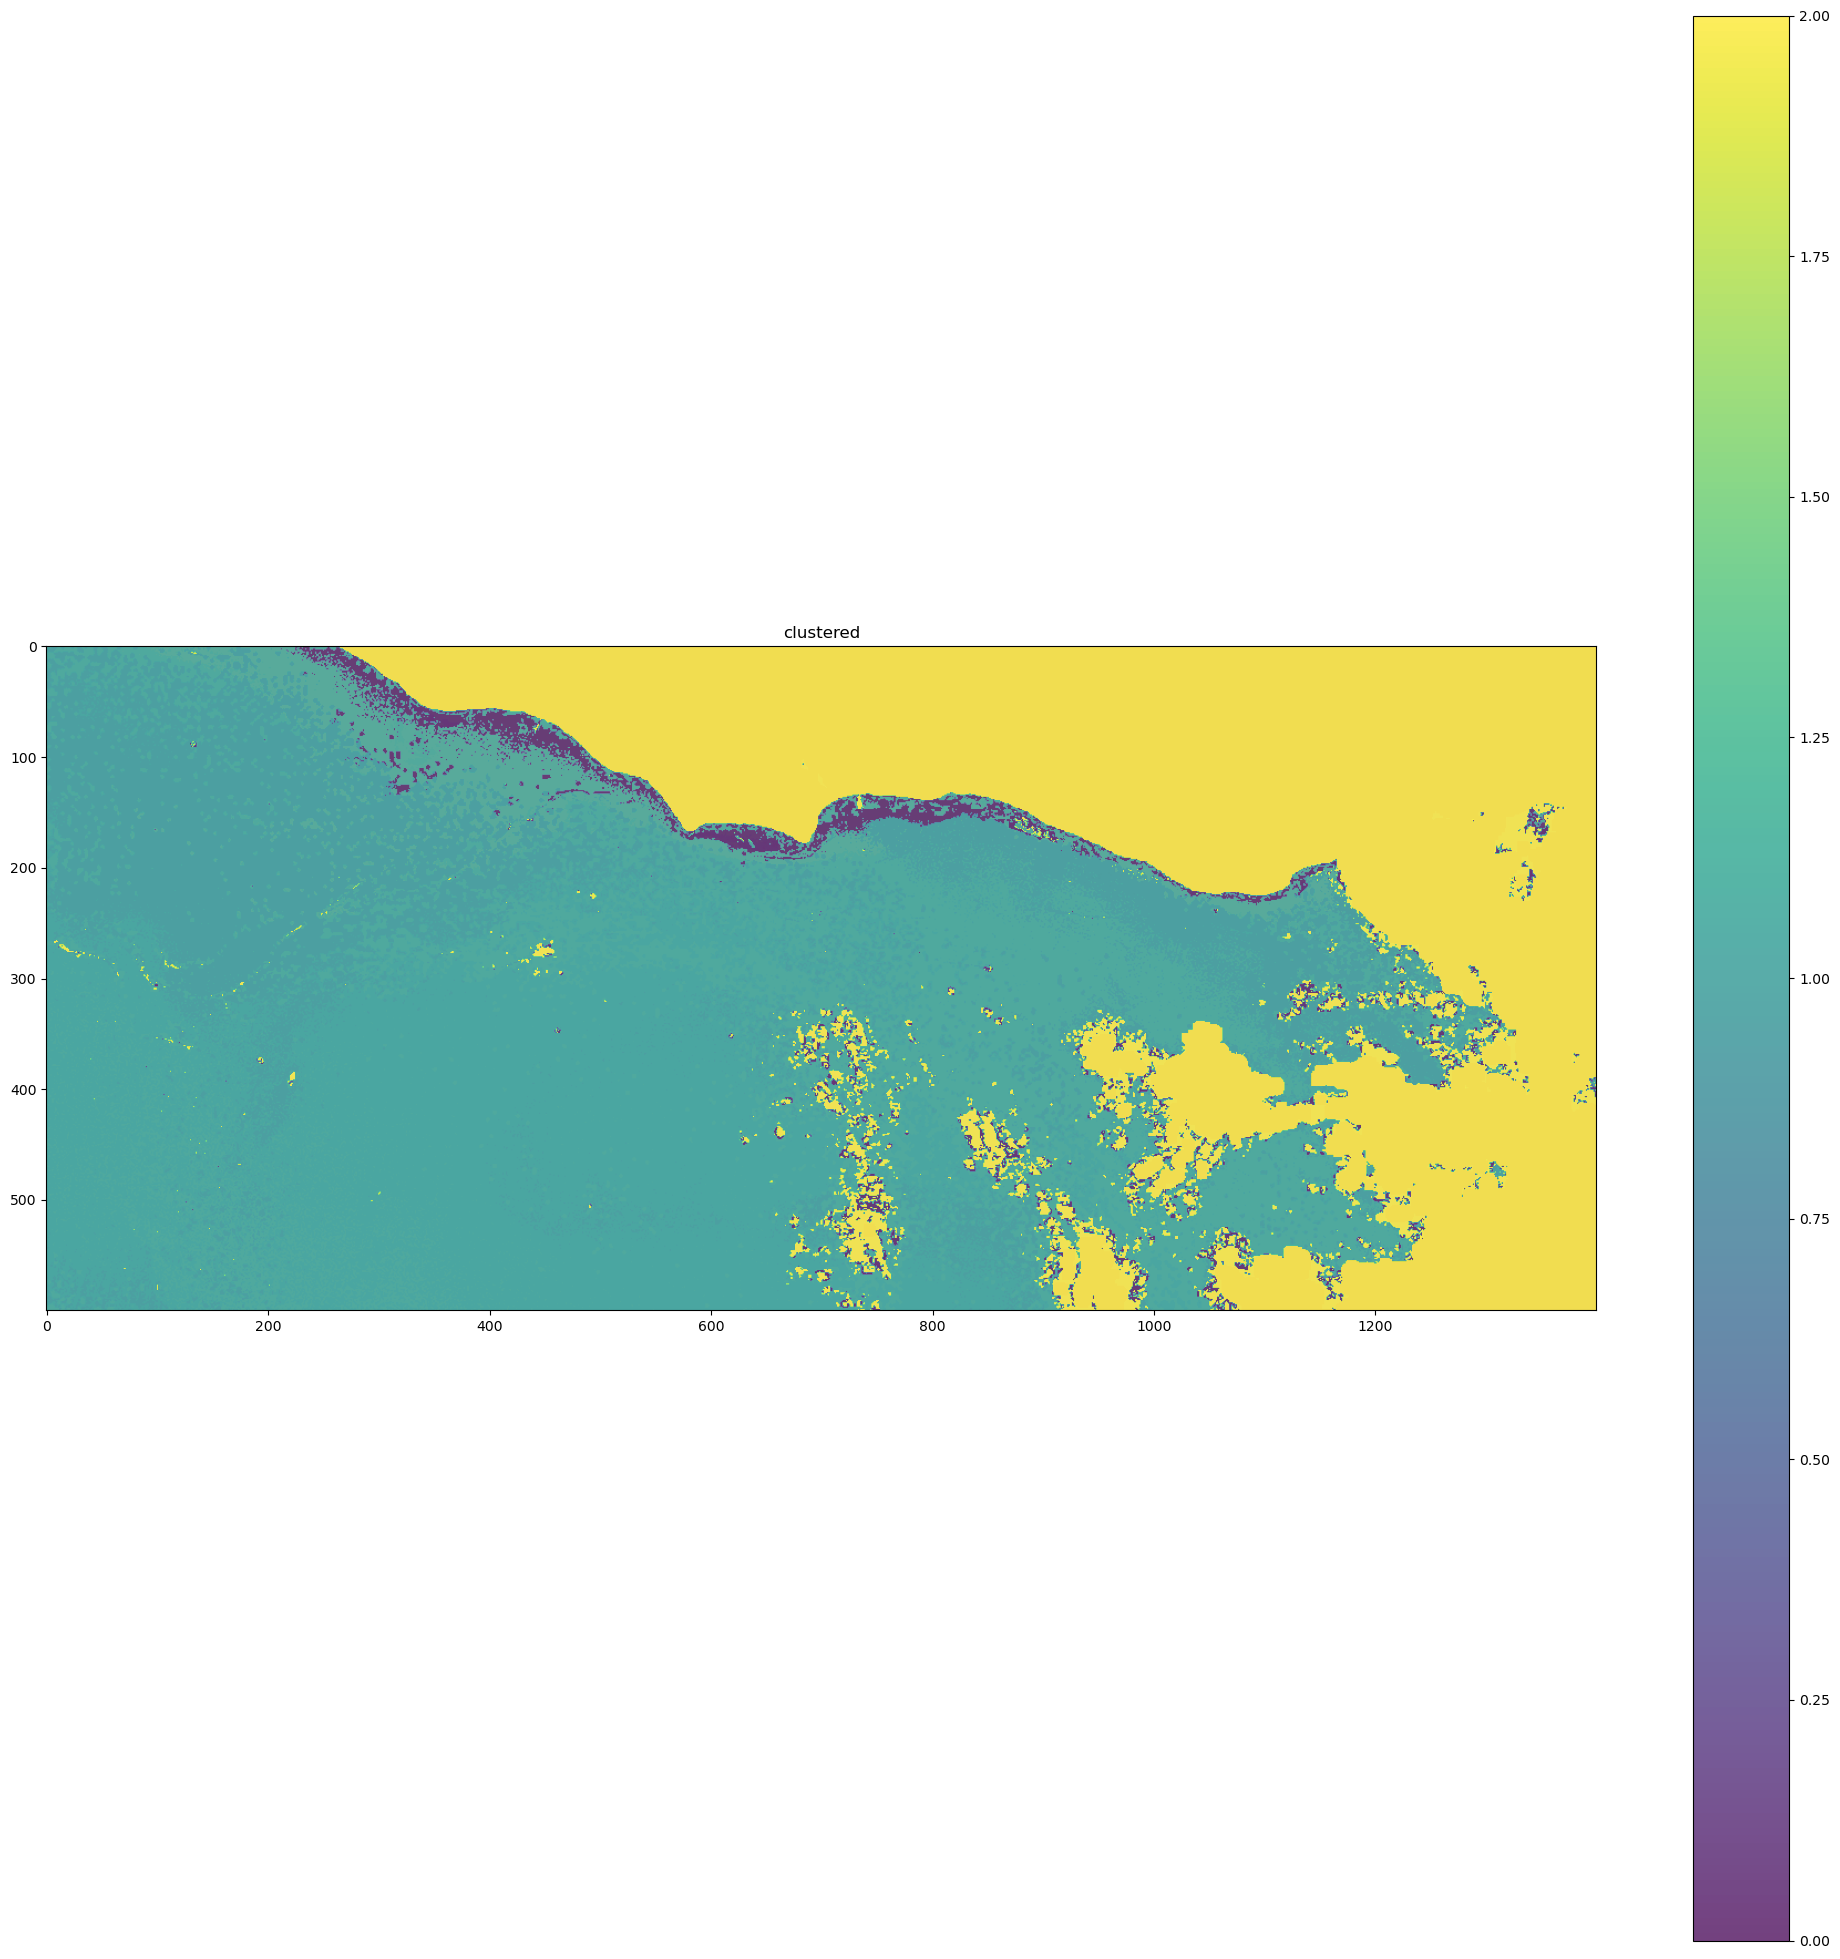

In [494]:
cloud_mask_1 = np.zeros_like(kmeans_1)
clustering_1 = np.copy(kmeans_1)
clouds_land_1 = [0,7,13,4]#[1,2,3,4,5,7,8,9]

kelp_1 = [10,9,6,5,3]
ocean_1 = [14,12,11,8,2,1]

cloud_land_mask_1 = np.isin(kmeans_1, clouds_land_1)
clustering_1[cloud_land_mask_1] = 2
kelp_mask_1 = np.isin(kmeans_1, kelp_1)
clustering_1[kelp_mask_1] = 0
ocean_mask_1 = np.isin(kmeans_1,ocean_1)

clustering_1[ocean_mask_1] = 1
clustering_1_cropped = clustering_1[2800:3400,600:2000]
kmeans_1_cropped = kmeans_1[2800:3400,600:2000]
plt.figure(figsize=(25, 25))
plt.imshow(kmeans_1_cropped,  alpha=.25)
plt.imshow(clustering_1_cropped, alpha=.75)
plt.title('clustered')
plt.colorbar()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


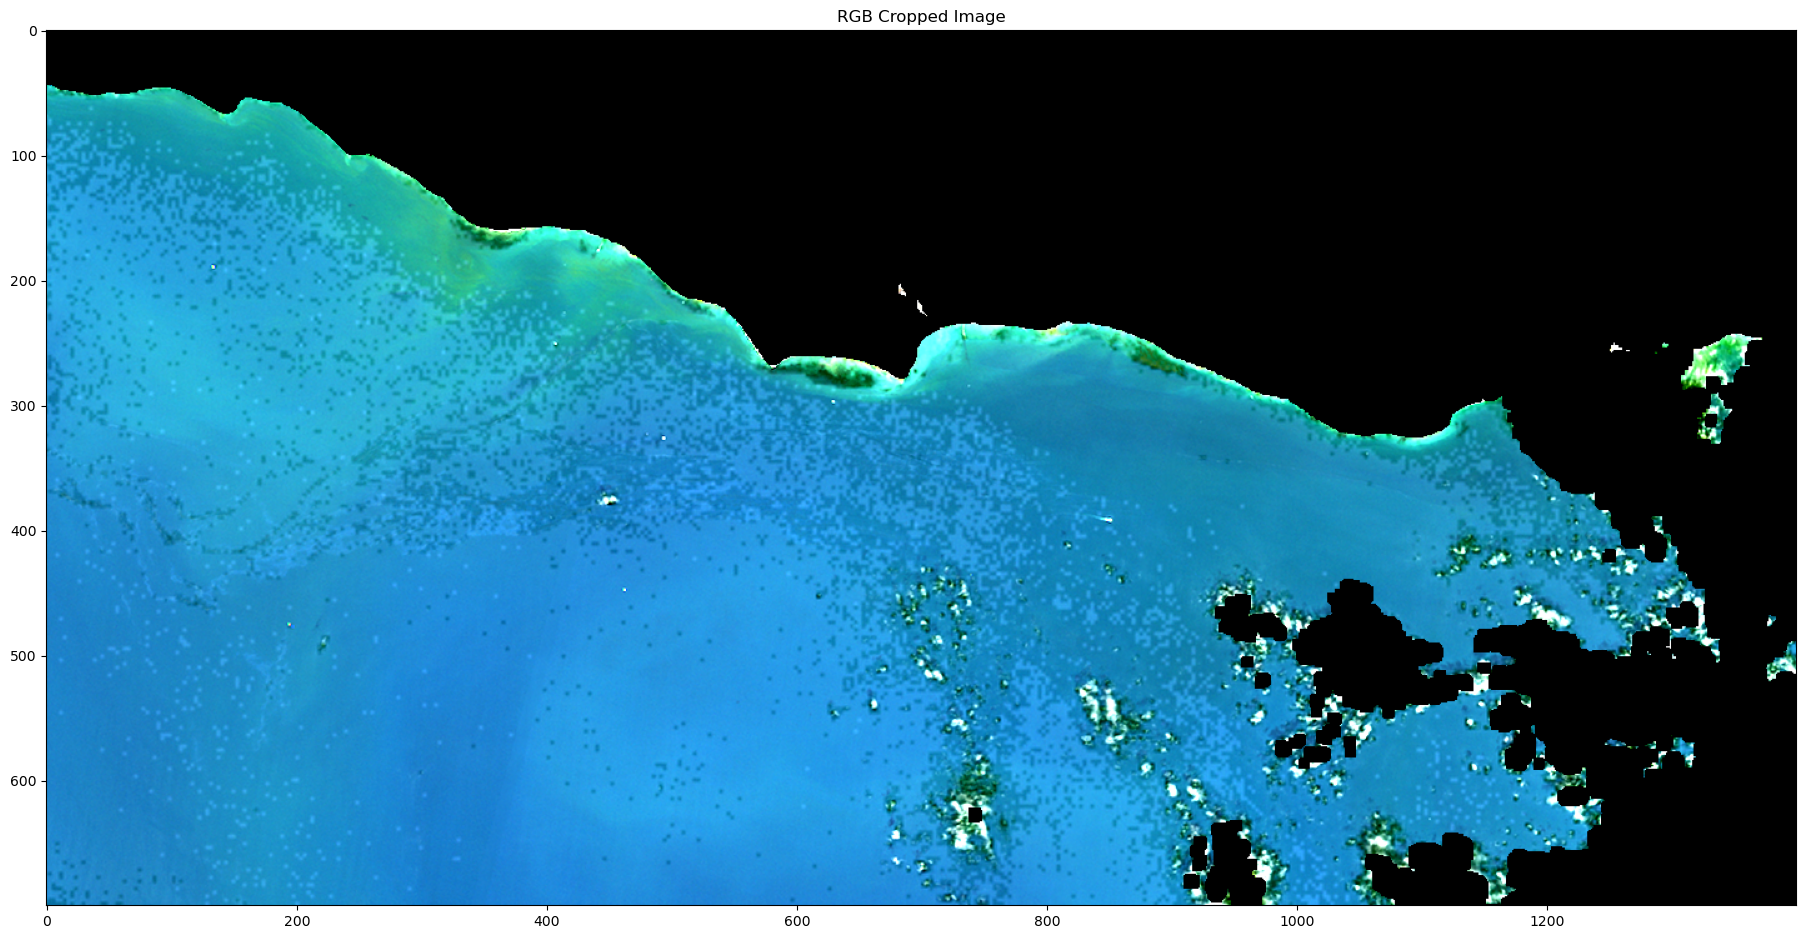

In [495]:
r_nor = img_2D[:,2].reshape((height, width))
g_nor = img_2D[:,1].reshape((height, width))
b_nor = img_2D[:,0].reshape((height, width))
rgb_nor = np.stack([r_nor,g_nor,b_nor], axis=-1)
#rgb_nor_cropped = rgb_nor#[2500:3400,600:2000]

rgb_cropped = rgb_nor[2700:3400, 600:2000]
plt.figure(figsize=(25, 25))
plt.subplot(2, 1, 2) 
plt.imshow(rgb_cropped)
plt.title("RGB Cropped Image")
plt.show()

In [496]:
empty_band = np.zeros(len(img_2D[0,:]))
kmeans_1_2D = clustering_1.reshape(-1).T

kmeans_1_landmask = np.copy(img_2D)
for i, ocean_pixel in enumerate(kmeans_1_2D):
    if not ocean_pixel == 0:
        kmeans_1_landmask[i,:] = empty_band

In [497]:
n_clusters_2 = 8
kmeans = KMeans(n_clusters=n_clusters_2, random_state=31)
clusters_2 = kmeans.fit_predict(kmeans_1_landmask)
kmeans_2 = clusters_2.reshape((height, width))

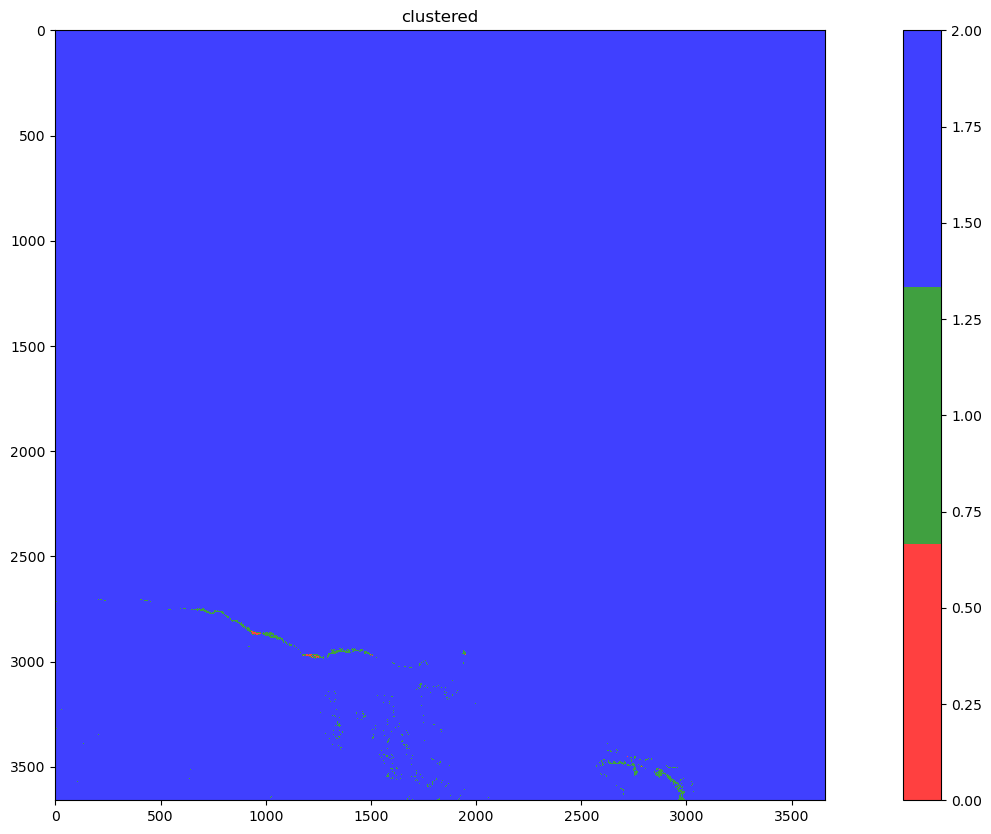

In [513]:
# 0 = kelp, 1 = ocean, 2 = misc (land,clouds)
cloud_mask_2 = np.zeros_like(kmeans_2)
kelp_mask_2 = np.zeros_like(kmeans_2)
misc_mask_2 = np.zeros_like(kmeans_2)

clustering_2 = np.copy(kmeans_2)
ocean_2 = [7,6,2,5]#[1,2,3,4,5,7,8,9]
misc_2 = [0]
kelp_2 = [4,3,1]
kelp_mask_2 = np.isin(kmeans_2, kelp_2)
clustering_2[kelp_mask_2] = 0
ocean_mask_2 = np.isin(kmeans_2, ocean_2)
clustering_2[ocean_mask_2] = 1
misc_mask_2 = np.isin(kmeans_2,misc_2)
clustering_2[misc_mask_2] = 2

clustering_2_cropped = clustering_2#[2700:3400, 600:2000] #[2500:3600,0:3600]
kmeans_2_cropped = kmeans_2[2700:3400, 600:2000]#[2500:3600,0:36000]
colors = ['red', 'green', 'blue']
cmap_custom = ListedColormap(colors)


plt.figure(figsize=(20, 10))
#plt.imshow(kmeans_2_cropped, cmap='tab10', alpha=0)
plt.imshow(clustering_2_cropped, cmap=cmap_custom, alpha=.75)
plt.title('clustered')
# Plotting the HLS data in red
#plt.imshow(img_cropped, cmap='grey', alpha=.5)
plt.colorbar()
plt.show()

In [387]:
if False:
    empty_band = np.zeros(len(img_2D[0,:]))
    kmeans_1_2D = clustering_2.reshape(-1).T

    kmeans_1_landmask = np.copy(img_2D)
    for i, ocean_pixel in enumerate(kmeans_1_2D):
        if not ocean_pixel == 0:
            kmeans_1_landmask[i,:] = empty_band

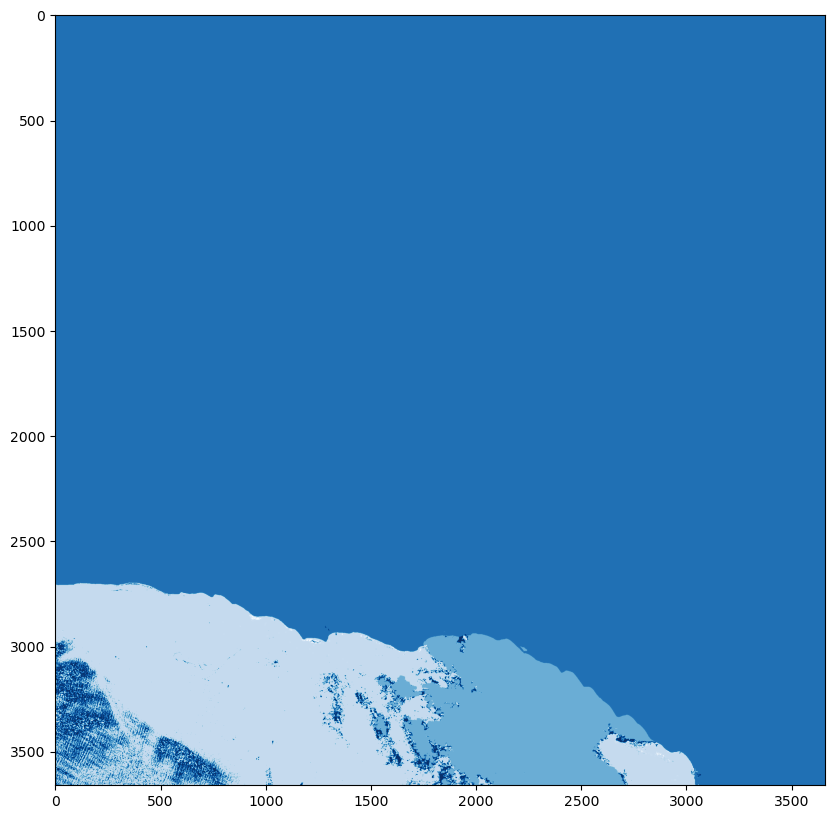

In [514]:
ocean_mask = (clustering_2 == 1) | (clustering_1 == 1)
kelp_mask = (clustering_2 == 0) 
#cloud_but_not_land_mask #This is a reminder to use this pre-made mask 

combined_mask = np.full(kelp_mask.shape, 4)
combined_mask[land_mask == 1] = 3
combined_mask[cloud_but_not_land_mask == 1] = 2
combined_mask[ocean_mask == 1] = 1
combined_mask[kelp_mask == 1] = 0

plt.figure(figsize=(20, 10))
plt.imshow(combined_mask, cmap='Blues')
plt.show()

#print(combined_mask[0:20,0:20])

In [515]:
img_bands_2 =[]
try:
    for file in img_files:
        with rasterio.open(os.path.join(img_path, file)) as src:
            img_bands_2.append(np.where(land_mask, 0, src.read(1)))  # Create image with the various bands
except RasterioIOError as e:
    print(f"Error reading file {file} in granule {item}: {e}")

img = np.stack(img_bands_2, axis=0)
n_bands, height, width = img.shape
img_2D = img.reshape(img.shape[0], -1).T #classifier takes 2D array of band values for each pixel 
img_sum = img_2D.sum(axis=1)
epsilon = 1e-10  

img_2D_normalized = np.divide(img_2D, img_sum[:, None] + epsilon, where=(img_sum[:, None] != 0))
img_2D_normalized = (img_2D_normalized * 255).astype(np.uint8)



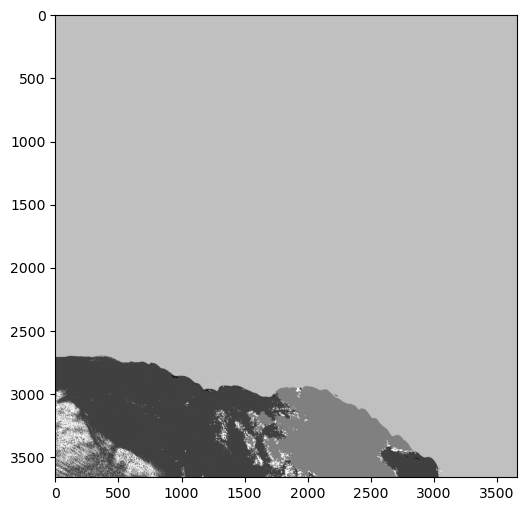

In [516]:
if save_classification:
    if not os.path.isdir (r'C:\Users\attic\HLS_Kelp\imagery\rf_training_V2'):
        os.mkdir(r'C:\Users\attic\HLS_Kelp\imagery\rf_training_V2')
    classification_path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery\rf_training_V2',f'{item}_kelp_classified.tif')
    transform = dst.transform  
    height, width = clustering_2.shape
    reshaped_normalized_img = img_2D_normalized.reshape(height, width, 6)
    combined_img = np.dstack((reshaped_normalized_img, combined_mask))

    plt.figure(figsize=(6, 6))
    plt.imshow(combined_img[:,:,6], cmap='gray')
    plt.show()  

    num_bands = 7
    data_type = rasterio.uint8
    profile = {
        'driver': 'GTiff',
        'width': width,
        'height': height,
        'count': 7,  # one band
        'dtype': data_type,  # assuming binary mask, adjust dtype if needed
        'crs': dst.crs,
        'transform': transform,
        'nodata': 0  # assuming no data is 0
    }
    # Write the land mask array to GeoTIFF
    with rasterio.open(classification_path, 'w', **profile) as dst:
        for i in range(num_bands):
            dst.write(combined_img[:,:,i].astype(data_type), i + 1)